In [1]:
import pandas as pd
import numpy as np
import pubchempy as pcp
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from skopt.plots import plot_convergence
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from matplotlib import pyplot as plt

In [2]:
scaler = StandardScaler()

In [3]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\important\RON_database_for_EF.csv',encoding="cp1252")

##### df - dataset to compare predictions with
df = df.dropna(axis = 0)
ron = pd.read_csv(r'C:\Users\zcemg08\Desktop\algo\ron_database_v1.0.csv',low_memory=False)
ron.columns = ron.iloc[0].values
ron = ron.drop(0,axis=0)
ron = ron[['Compound Name','PubChem CID','TARGET','SMILES']]
ron_biocompound = pd.read_table(r'C:\Users\zcemg08\Desktop\algo\RON.txt')
df_merged = df.merge(ron,on=['SMILES'],how='left')

ans = pd.read_csv(r'C:\Users\zcemg08\Desktop\algo\RON_database_for_EF.csv')

In [4]:
df = df.merge(ans,on=['SMILES'],how='left')
col = ['RON_Molecules_x','SMILES','Data Set','Exeriment']
df = df[col]

In [5]:
df.head(5)

,RON_Molecules_x,SMILES,Data Set,Exeriment
0,n-Butylbenzene,CCCCc1ccccc1,Training,104.4
1,"1,2,3,4-Tetramethylbenzene",Cc1c(C)ccc(c1C)C,Training,105.3
2,1-Phenylpentane,CCCCCc1ccccc1,Training,89.2
3,1-Methyl-2-allylbenzene,C=CCc1ccccc1C,Training,98.6
4,"1,2,3,4-Tetrahydronaphthalene",C1CCc2c(C1)cccc2,Training,96.4


In [6]:
calc = Calculator(descriptors, ignore_3D=False)
mols = [Chem.MolFromSmiles(smi) for smi in list(df['SMILES'].values)]
df_descriptors = calc.pandas(mols)

100%|██████████| 276/276 [00:22<00:00, 12.27it/s]


In [7]:
df_descriptors = df_descriptors.loc[:, (df_descriptors != df_descriptors.iloc[0]).any()] 
df_descriptors = df_descriptors.loc[:,~df_descriptors.columns.duplicated()]
df_descriptors = df_descriptors.dropna(axis=1, how='all')

df_descriptors = df_descriptors._get_numeric_data()

In [8]:
df_octane = pd.concat([df,df_descriptors],axis=1)

In [10]:
df_octane.head(-7)

,RON_Molecules_x,SMILES,Data Set,Exeriment,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,n-Butylbenzene,CCCCc1ccccc1,Training,104.4,7.071068,6.547760,12.932143,2.154341,4.308683,12.932143,...,8.438366,38.130322,134.109550,5.587898,133,9,42.0,44.0,3.111111,2.500000
1,"1,2,3,4-Tetramethylbenzene",Cc1c(C)ccc(c1C)C,Training,105.3,7.387307,7.212008,12.250296,2.318014,4.636027,12.250296,...,9.122711,39.843188,134.109550,5.587898,109,14,48.0,55.0,4.944444,2.250000
2,1-Phenylpentane,CCCCCc1ccccc1,Training,89.2,7.778175,7.057066,13.983360,2.156639,4.313279,13.983360,...,8.491465,39.504541,148.125201,5.486119,182,10,46.0,48.0,3.361111,2.750000
3,1-Methyl-2-allylbenzene,C=CCc1ccccc1C,Training,98.6,7.140017,6.833492,12.527715,2.230994,4.461989,12.527715,...,8.746875,38.855012,132.093900,6.004268,121,11,44.0,48.0,3.722222,2.444444
4,"1,2,3,4-Tetrahydronaphthalene",C1CCc2c(C1)cccc2,Training,96.4,7.737734,6.634763,13.683239,2.302776,4.605551,13.683239,...,9.066816,39.856521,132.093900,6.004268,109,12,50.0,57.0,2.222222,2.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,3-Methyl-2-hexene (trans),CCC/C(=C/C)/C,Test,91.4,4.352030,4.798324,7.878462,1.969616,3.939231,7.878462,...,7.486053,31.656710,98.109550,4.671883,50,5,24.0,23.0,3.861111,1.916667
265,"2,3-Dimethyl-1-butene",CC(=C)C(C)C,Test,101.3,3.932653,4.244375,6.000000,2.000000,4.000000,6.000000,...,7.626083,30.698690,84.093900,4.671883,29,4,22.0,21.0,4.222222,1.444444
266,Isopropylcyclopropane,CC(C1CC1)C,Test,100.3,4.420980,4.187572,7.191688,2.278414,4.169633,7.191688,...,8.383205,51.169989,84.093900,4.671883,28,4,28.0,31.0,2.722222,1.361111
267,"2,2-Dimethyl-3-ethylpentane",CCC(C(C)(C)C)CC,Test,112.1,6.072001,6.682893,9.300563,2.236068,4.472136,9.300563,...,8.751000,37.448312,128.156501,4.419190,88,10,38.0,40.0,5.673611,2.166667


In [11]:
descriptors = list(df_octane)[4:]

In [12]:
X_train_validate = df_octane[df_octane['Data Set'].isin(['Training','Validation'])][descriptors].values
Y_train_validate = df_octane[df_octane['Data Set'].isin(['Training','Validation'])]['Exeriment'].values

scaler.fit(X_train_validate)

X_train_validate = scaler.transform(X_train_validate)


X_test = df_octane[df_octane['Data Set'] == 'Test'][descriptors].values

X_test = scaler.transform(X_test)
Y_test = df_octane[df_octane['Data Set'] == 'Test']['Exeriment'].values

In [13]:
reg = SVR(gamma='auto')


# Build step forward feature selection
sfs1 = sfs(reg,
           k_features=25,
           forward=True,
           floating=False,
           verbose=0,
           scoring='neg_mean_squared_error',
           cv=10)

# Perform SFFS
sfs1 = sfs1.fit(X_train_validate, Y_train_validate)

index = np.array(sfs1.k_feature_idx_)
selected_features = np.take(descriptors,index)


In [14]:
index = np.array(sfs1.k_feature_idx_)
np.take(np.array(descriptors),index)

array(['VE2_A', 'nAromAtom', 'ATS5s', 'AATS3m', 'MATS2se', 'GATS2v',
       'GATS2se', 'GATS2pe', 'GATS2are', 'GATS2p', 'GATS2i', 'C3SP2',
       'Xch-3d', 'Xch-3dv', 'VE2_Dt', 'NddC', 'NdssC', 'SssCH2', 'SdssC',
       'CIC0', 'CIC1', 'GhoseFilter', 'EState_VSA8', 'VSA_EState4',
       'JGI4'], dtype='<U14')

In [15]:
selected_features = np.take(np.array(descriptors),index)

In [16]:
selected_features

array(['VE2_A', 'nAromAtom', 'ATS5s', 'AATS3m', 'MATS2se', 'GATS2v',
       'GATS2se', 'GATS2pe', 'GATS2are', 'GATS2p', 'GATS2i', 'C3SP2',
       'Xch-3d', 'Xch-3dv', 'VE2_Dt', 'NddC', 'NdssC', 'SssCH2', 'SdssC',
       'CIC0', 'CIC1', 'GhoseFilter', 'EState_VSA8', 'VSA_EState4',
       'JGI4'], dtype='<U14')

In [17]:
X_train_validate = df_octane[df_octane['Data Set'].isin(['Training','Validation'])][selected_features].values
X_train_validate = scaler.fit_transform(X_train_validate)

In [18]:
reg = SVR()

space  = [Real(10**-3, 10**3,"log-uniform", name='C'),
          Real(10**-3, 10**-1,"log-uniform", name='gamma'),
         Real(0.03,0.4,name='epsilon')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train_validate, Y_train_validate, cv=10, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0, n_random_starts=5)

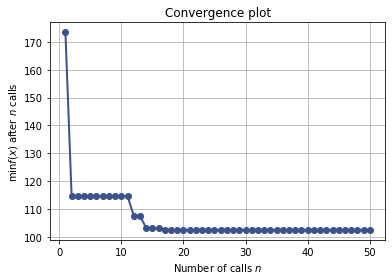

In [19]:
plot_convergence(res_gp)

In [20]:
reg.C = res_gp.x[0]
reg.gamma = res_gp.x[1]
reg.epsilon = res_gp.x[2]

reg.fit(X_train_validate,Y_train_validate)

SVR(C=66.49233650559549, epsilon=0.4, gamma=0.06102472346964923)

In [21]:
X_train_validate.shape

(250, 25)

In [22]:
print ('RMSE = {}'.format(np.sqrt(mean_squared_error(Y_train_validate, reg.predict(X_train_validate)))))
print ('R2 = {}'.format(r2_score(reg.predict(X_train_validate),Y_train_validate)))
print ('AAE = {}'.format(mean_absolute_error(reg.predict(X_train_validate),Y_train_validate)))


RMSE = 6.234617520693975
R2 = 0.9296049358739026
AAE = 3.3257619815172497


In [23]:
X_test = df_octane[df_octane['Data Set']== 'Test'][selected_features].values
X_test = scaler.transform(X_test)

In [24]:
print ('RMSE = {}'.format(np.sqrt(mean_squared_error(Y_test, reg.predict(X_test)))))
print ('R2 = {}'.format(r2_score(reg.predict(X_test),Y_test)))
print ('AAE = {}'.format(mean_absolute_error(reg.predict(X_test),Y_test)))

RMSE = 5.417076723222896
R2 = 0.8628796103432315
AAE = 4.325546819098878


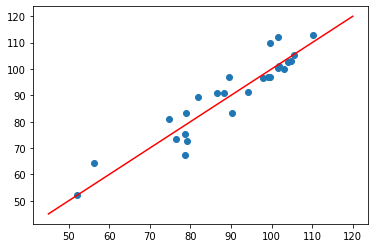

In [25]:
plt.scatter(reg.predict(X_test),Y_test)

x = np.linspace(45,120)
y = x

plt.plot(x, y, '-r', label='ideal')
plt.show()

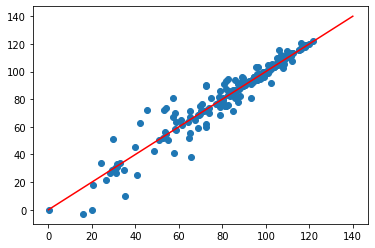

In [26]:
plt.scatter(reg.predict(X_train_validate),Y_train_validate)

x = np.linspace(0,140)
y = x

plt.plot(x, y, '-r', label='ideal')
plt.show()

In [27]:
type(calc)

mordred._base.calculator.Calculator

In [28]:
selected_features

array(['VE2_A', 'nAromAtom', 'ATS5s', 'AATS3m', 'MATS2se', 'GATS2v',
       'GATS2se', 'GATS2pe', 'GATS2are', 'GATS2p', 'GATS2i', 'C3SP2',
       'Xch-3d', 'Xch-3dv', 'VE2_Dt', 'NddC', 'NdssC', 'SssCH2', 'SdssC',
       'CIC0', 'CIC1', 'GhoseFilter', 'EState_VSA8', 'VSA_EState4',
       'JGI4'], dtype='<U14')

In [106]:
#calc = Calculator(descriptors, ignore_3D=False)
mols = [Chem.MolFromSmiles(smi) for smi in ['CC1CCC(=O)O1','CNC1=CC=CC=C1']]
df_descriptors = calc.pandas(mols)

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


In [101]:
#calc = Calculator(descriptors, ignore_3D=False)
mols = [Chem.MolFromSmiles(smi) for smi in ['CCCC(C)CC','CC(C)(C)C=C']]
df_descriptors = calc.pandas(mols)

100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


In [107]:
x_test_compound = df_descriptors[selected_features]

In [108]:
x_test_compound.shape

(2, 25)

In [109]:
x_test_compound = scaler.transform(x_test_compound)

In [110]:
reg.predict(x_test_compound)

array([100.39976935,  97.31280446])